In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import sys
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as patches
import matplotlib.colors as clr
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib import collections  as mc
import matplotlib.colors as clr
from matplotlib.ticker import FuncFormatter
import matplotlib.lines as mlines

sys.path.append("scripts/")
import scripts.conf as conf
import scripts.oncotree
conf.config_params()
oncotree = scripts.oncotree.Oncotree()

os.makedirs("raw_plots",exist_ok=True)
os.makedirs("source_data",exist_ok=True)

In [3]:
if not(os.path.exists("source_data/model_information_including_generals.tsv.gz")):
    ! python3 scripts/prepare_table_model_types.py

# Extended Figure 8, panel 8b

### First, load the source data.

In [4]:
df_table_ratios = pd.read_csv("source_data/ratio_models_by_tumor_type_model.tsv",sep="\t")
df_table_ratios.set_index("CANCER_TYPE",inplace=True)
df = pd.read_csv("source_data/unique_observed_mutations_with_type_model.tsv.gz",sep="\t")
# save the total counts (barplots in the heatmap)
d_counts,d_counts_total = defaultdict(lambda: 0.0), defaultdict(lambda: 0.0) 
for type_model,ttype,count in df.groupby(["type_model","CANCER_TYPE"],as_index=False).agg({"pos":"count"}).values:
    d_counts[(type_model,ttype)] = count
for ttype,count in df.groupby(["CANCER_TYPE"],as_index=False).agg({"pos":"count"}).values:
    d_counts_total[ttype] = count

### Prepare the data for plotting, including colors

In [5]:
order_categories=df_table_ratios.T.index
order_ttypes=list(df_table_ratios.T.columns.values)
dict_colors = {"gene/ttype specific":"#e6550d","gene specific":"#fdae6b","gene other ttype":"#fee6ce","no-model":"white"}
x=df[["gene","CANCER_TYPE","type_model"]].drop_duplicates().values
ttypes = set(df["CANCER_TYPE"].unique())
d_data = defaultdict(lambda: "white")
for gene,ttype,type_model in x:
    d_data[(gene,ttype)]=dict_colors[type_model]

### Generate a row per gene...

In [6]:
x=df.groupby(["gene","CANCER_TYPE"]).agg({"pos":"count"}).sort_values("pos",ascending=False)
x.reset_index(inplace=True)
heatmap_total = x.pivot_table(index="gene",values="pos",columns=["CANCER_TYPE"]).fillna(0.0)[order_ttypes]
order_genes = heatmap_total.sum(axis=1).sort_values(ascending=False).index[0:20]

### Select top genes (manual selection, as an example, any other gene could be selected)

In [7]:
selected_genes = ["TP53","KRAS","PTEN","PIK3CA","CTNNB1","RB1","FBXW7","ARID1A","VHL","EGFR","IDH1","NOTCH1","APC","BRAF","SMAD4","NF1","NFE2L2","ALK","CDKN2A","KMT2D"]
x=df[df["gene"].isin(selected_genes)].groupby(["gene","CANCER_TYPE"]).agg({"pos":"count"}).sort_values("pos",ascending=False)
x.reset_index(inplace=True)
order_ttypes_n = [ttype  for ttype in order_ttypes if (ttype in x["CANCER_TYPE"].unique()) and ttype in  df[(df["gene"].isin(selected_genes))&(df["type_model"]=="gene/ttype specific")]["CANCER_TYPE"].unique() ]
heatmap_total = x.pivot_table(index="gene",values="pos",columns=["CANCER_TYPE"]).fillna(0.0)[order_ttypes_n]
count_genes = heatmap_total.sum(axis=1).sort_values(ascending=False)
max_counts=np.nanmax(count_genes.values)
order_genes = list(heatmap_total.sum(axis=1).sort_values(ascending=False).index[0:20])

### Function to create the legend...

In [8]:
def create_legend():
    c = ["Gene/tumor type specific","Tumor type specific","Gene specific", "Other general"]
    colors = ["#762a83","#af8dc3","#1b7837","#7fbf7b"]
              
    l = []
    for i in range(0,len(c)):
        l.append(mlines.Line2D([], [], color=colors[i], marker='.', markersize=25, label=c[i],lw=0.0))
    return l

### Render the plot!

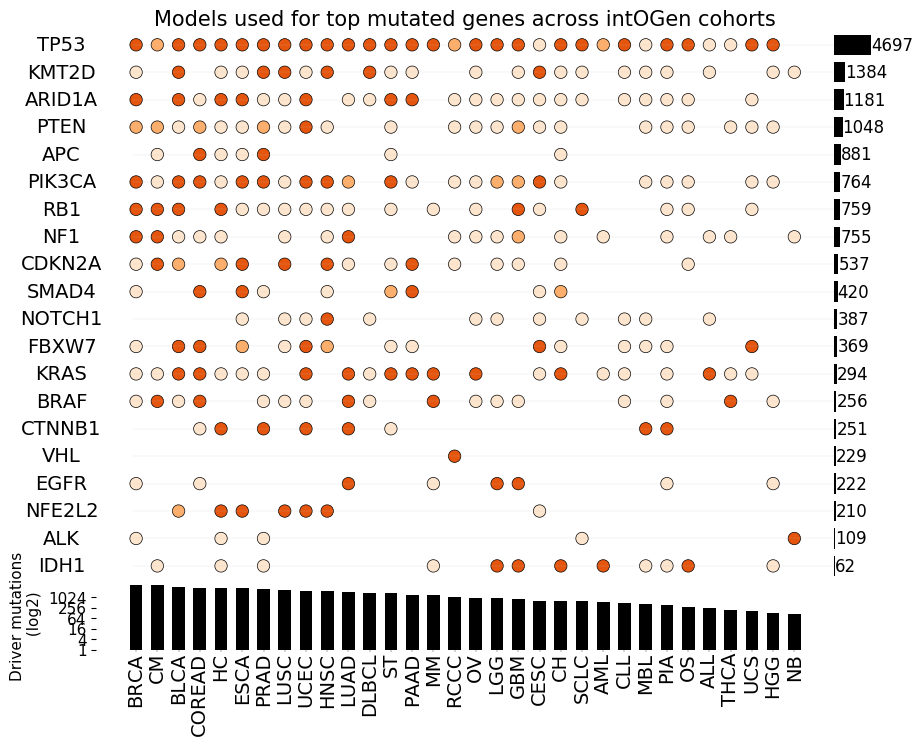

In [9]:
fig,ax=plt.subplots(figsize=(10,8))
N=len(order_genes)+1
gs = gridspec.GridSpec(ncols=2,nrows=N,height_ratios=[1 for x in range(0,len(order_genes))]+[3],width_ratios=[20,1],wspace=0.0)
ax0 = plt.subplot(gs[0]) 
ax1 = plt.subplot(gs[1]) 
axis = [ax0,ax1]
len_columns=len(order_ttypes_n)
for i in range(2,N*2,2):
    axis.append(plt.subplot(gs[i],sharex=ax0))
    axis.append(plt.subplot(gs[i+1],sharey=axis[-1]))
i = 0
for j in range(0,len(order_genes)*2,2):
    ax = axis[j]
    ax.get_xaxis().set_visible(False)
    #sizes = [np.nanmin([75,x/3])+35 if x > 0 else 0.0  for x in heatmap_total.loc[order_genes[i]].values]
    colors_gene = [d_data[(order_genes[i],v)] for v in order_ttypes_n]
    ax.scatter(x=list(range(1,len_columns+1)),y=np.zeros(len_columns),s=80,color=colors_gene,edgecolors=[ "black"  if color_gene != "white"   else "white" for color_gene in colors_gene ],linewidths=0.5,clip_on=False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set_xticks([])
    ax.axhline(y=0,xmin=0.05,xmax=1.1,color="#C0C0C0",lw=0.25,alpha=0.5)
    ax.set_ylabel(order_genes[i],fontsize=14,rotation=0,verticalalignment="center", labelpad=25)
    ax.set_yticks([])
    ax.set_xlabel("")
    i = i +1

i = 0
for j in range(1,len(order_genes)*2,2):
    ax = axis[j]
    ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    value = count_genes.loc[order_genes[i]]
    colors_gene = [d_data[(order_genes[i],v)] for v in order_ttypes_n]
    ax.barh(y=0,width=value,color="black",clip_on=True,height=0.8)
    ax.annotate(xy=(value+5,-0.2),s=str(int(value)),fontsize=12)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xlim(0,max_counts)
    i = i +1
ax=axis[-1]
ax.set_axis_off()
ax=axis[-2]
ax.bar(x=range(1,len(order_ttypes_n)+1),height=[np.log2(d_counts_total[ttype]) for ttype in order_ttypes_n],color="black",clip_on=False,width=0.6)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.get_xaxis().set_visible(True)
ax.set_ylabel("Driver mutations\n (log2)",fontsize=11)
ax.set_yticks([0,2,4,6,8,10])
ax.set_yticklabels([1,4,16,64,256,1024],fontsize=11)
ax.set_xticks(list(range(1,len_columns+1)))
ax.set_xticklabels(order_ttypes_n,rotation=90)
ax.tick_params(axis = 'x', labelsize =14  , pad=0.25,width=0.25, length = 1.5)
ax0.set_title("Models used for top mutated genes across intOGen cohorts",fontsize=15)
plt.savefig("raw_plots/top_genes_models_examples.pdf", dpi=800,bbox_inches="tight")
plt.show()
